In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pysal.model import mgwr
from scipy.stats import pearsonr
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from urbana.models.plot_predictions import PredictedAccuracy
from urbana.constants import DIR_REPO, DIR_DATA

/home/ernest/anaconda3/envs/urbana/lib/python3.9/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [4]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

OUTPUT_WARNINGS = False
VARIABLE_TO_PREDICT = "Airbnb_Number"
SAVE_FIGS = True

In [5]:
if not OUTPUT_WARNINGS:
    import warnings

    warnings.filterwarnings("ignore")

In [6]:
# Create folders to store the data
if SAVE_FIGS:
    folder_list = [
        DIR_DATA / "processed/02_gwr",
        DIR_DATA / "processed/02_gwr/coefficients",
    ]

    import os

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [7]:
sect = gpd.read_file(
    DIR_DATA / "interim/sections_geo.json",
)

sect.set_index("Tag", inplace=True)

sect.drop(
    ["N_district", "N_neighbourhood", "N_section"],
    axis=1,
    inplace=True,
)
sect.drop(["Percentage_Age_25_39"], axis=1, inplace=True)  # Duplicate


sect.isnull().sum(axis=0).sort_values(ascending=False).head(10)

Airbnb_Location_Score     89
Airbnb_Price_Person       55
Airbnb_Price              55
Rent_Area_Flats           19
Rent_Price_Total_Flats    19
Rent_Price_Meter_Flats    19
Rent_Number_Flats         10
Nationality_Colombia       0
Nationality_Argentina      0
Nationality_Venezuela      0
dtype: int64

In [8]:
id_max_airbnb = sect["Airbnb_Number"].idxmax()
print("Region with maximum value : " + str(id_max_airbnb))

Region with maximum value : 02_077


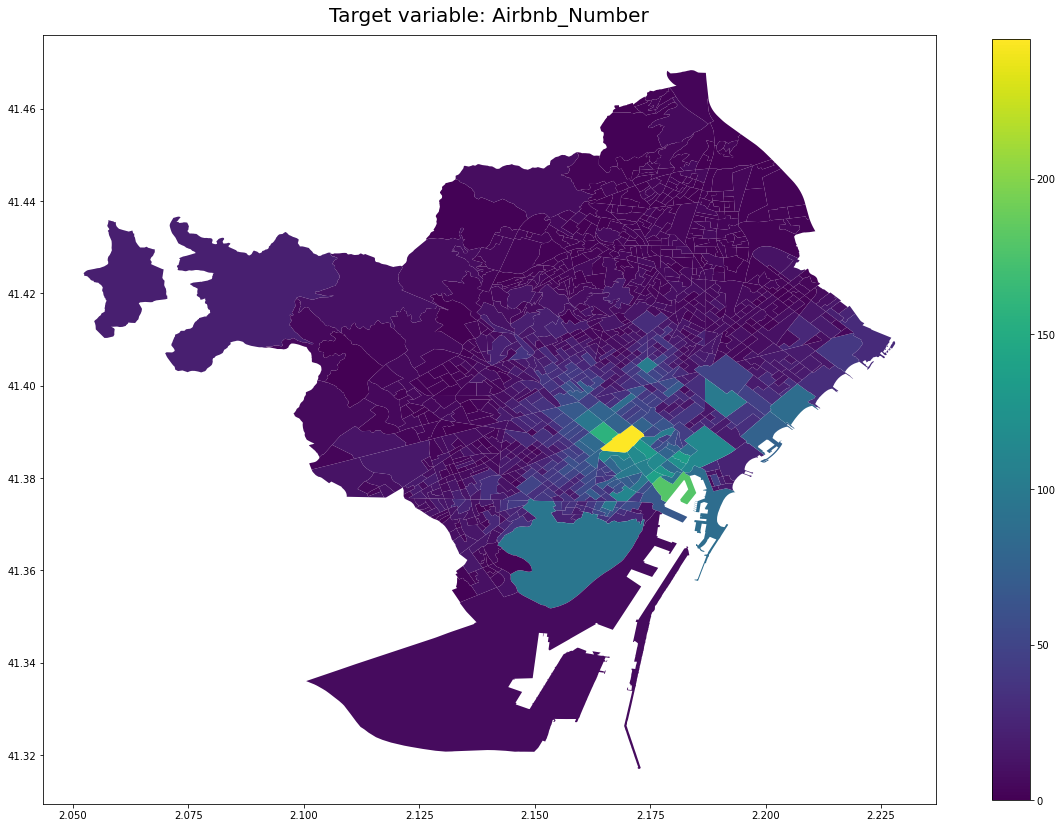

In [9]:
fig, ax = plt.subplots(figsize=(20, 20))

sect.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    legend=True,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Target variable: " + str(VARIABLE_TO_PREDICT), fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_DATA / "processed/02_gwr/target_variable.svg", format="svg")

plt.show()

In [10]:
y = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1))
X = sect.drop(
    [
        "Airbnb_Number",
        "Airbnb_Price",
        "Airbnb_Price_Person",
        "Airbnb_Location_Score",
        "geometry",
    ],
    axis=1,
)
coords = np.column_stack([sect["geometry"].centroid.x, sect["geometry"].centroid.y])

geo_info = sect[["geometry"]]
geo_info["centroid"] = geo_info["geometry"].centroid

In [11]:
geo_nans = sect[["geometry"]]
geo_nans["NaNs"] = pd.isnull(sect).sum(axis=1)

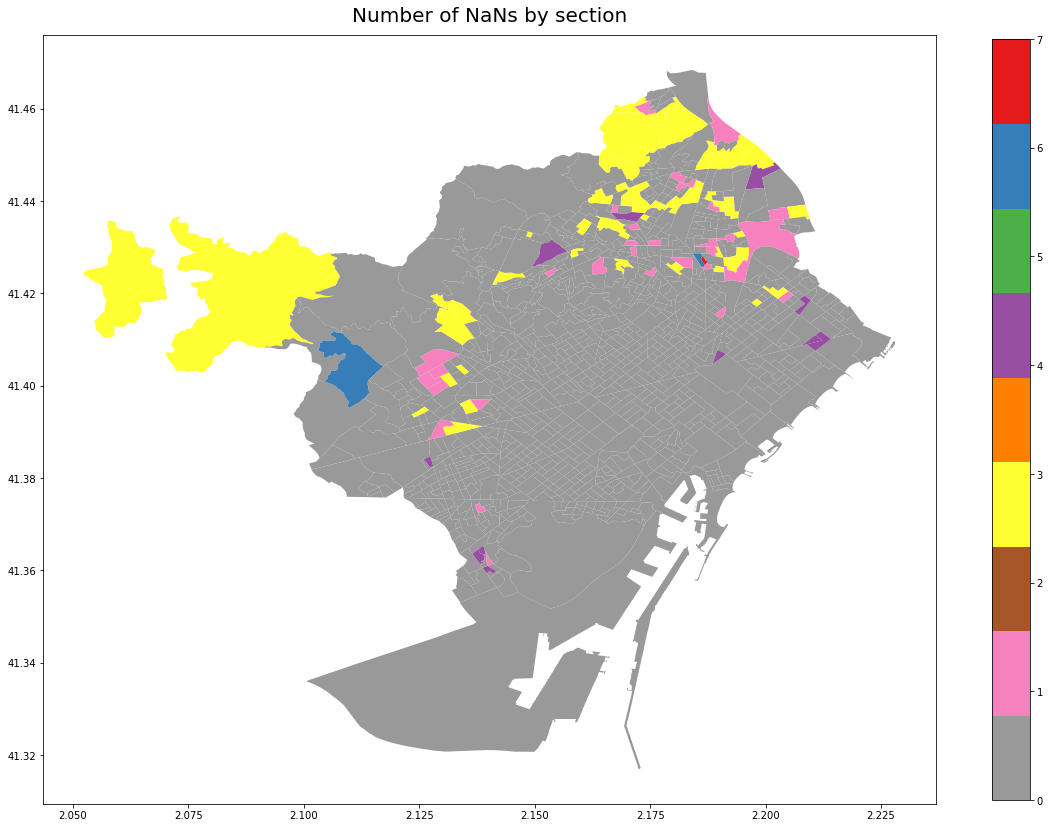

In [32]:
fig, ax = plt.subplots(figsize=(20, 20))

geo_nans.plot(
    ax=ax,
    column="NaNs",
    legend=True,
    cmap="Set1_r",
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of NaNs by section", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_DATA / "processed/02_gwr/nans.svg", format="svg")

plt.show()

In [13]:
X_num = np.array(X)

# We will input the missing values with an iterative imputer
imputer = IterativeImputer()
imputer.fit(X_num)
X_num = imputer.transform(X_num)

X_std = (X_num - X_num.mean(axis=0)) / X_num.std(axis=0)
y_std = (y - y.mean(axis=0)) / y.std(axis=0)

# GWR with all the features
All of the processes being modeled operate at the same spatial scale

# GWR with chosen and transformed


We first load the best model

In [14]:
with open("linear_best.txt") as f:
    best_model = f.read().splitlines()
X_chosen = sect[best_model]
y_chosen = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1))
print(best_model)

['Distance_Center', 'Nationality_UK', 'Nationality_Spain', 'POI_Restaurants_Hotels', 'Nationality_Italy', 'Percentage_Age_65_Plus', 'Percentage_Age_0_14', 'POI_Souvenirs_Thrift_Store']


Let's check if there are missing values for these features

In [15]:
pd.isnull(X_chosen).sum(0)

Distance_Center               0
Nationality_UK                0
Nationality_Spain             0
POI_Restaurants_Hotels        0
Nationality_Italy             0
Percentage_Age_65_Plus        0
Percentage_Age_0_14           0
POI_Souvenirs_Thrift_Store    0
dtype: int64

Since there are not missing values, we do not have to use a imputer.

We will transform the features so they follow a Gaussain-like distribution.

In [16]:
pw_X = PowerTransformer()
pw_X.fit(X_chosen)
X_transformed = pw_X.transform(X_chosen)

pw_y = PowerTransformer()
pw_y.fit(y_chosen)
y_transformed = pw_y.transform(y_chosen)

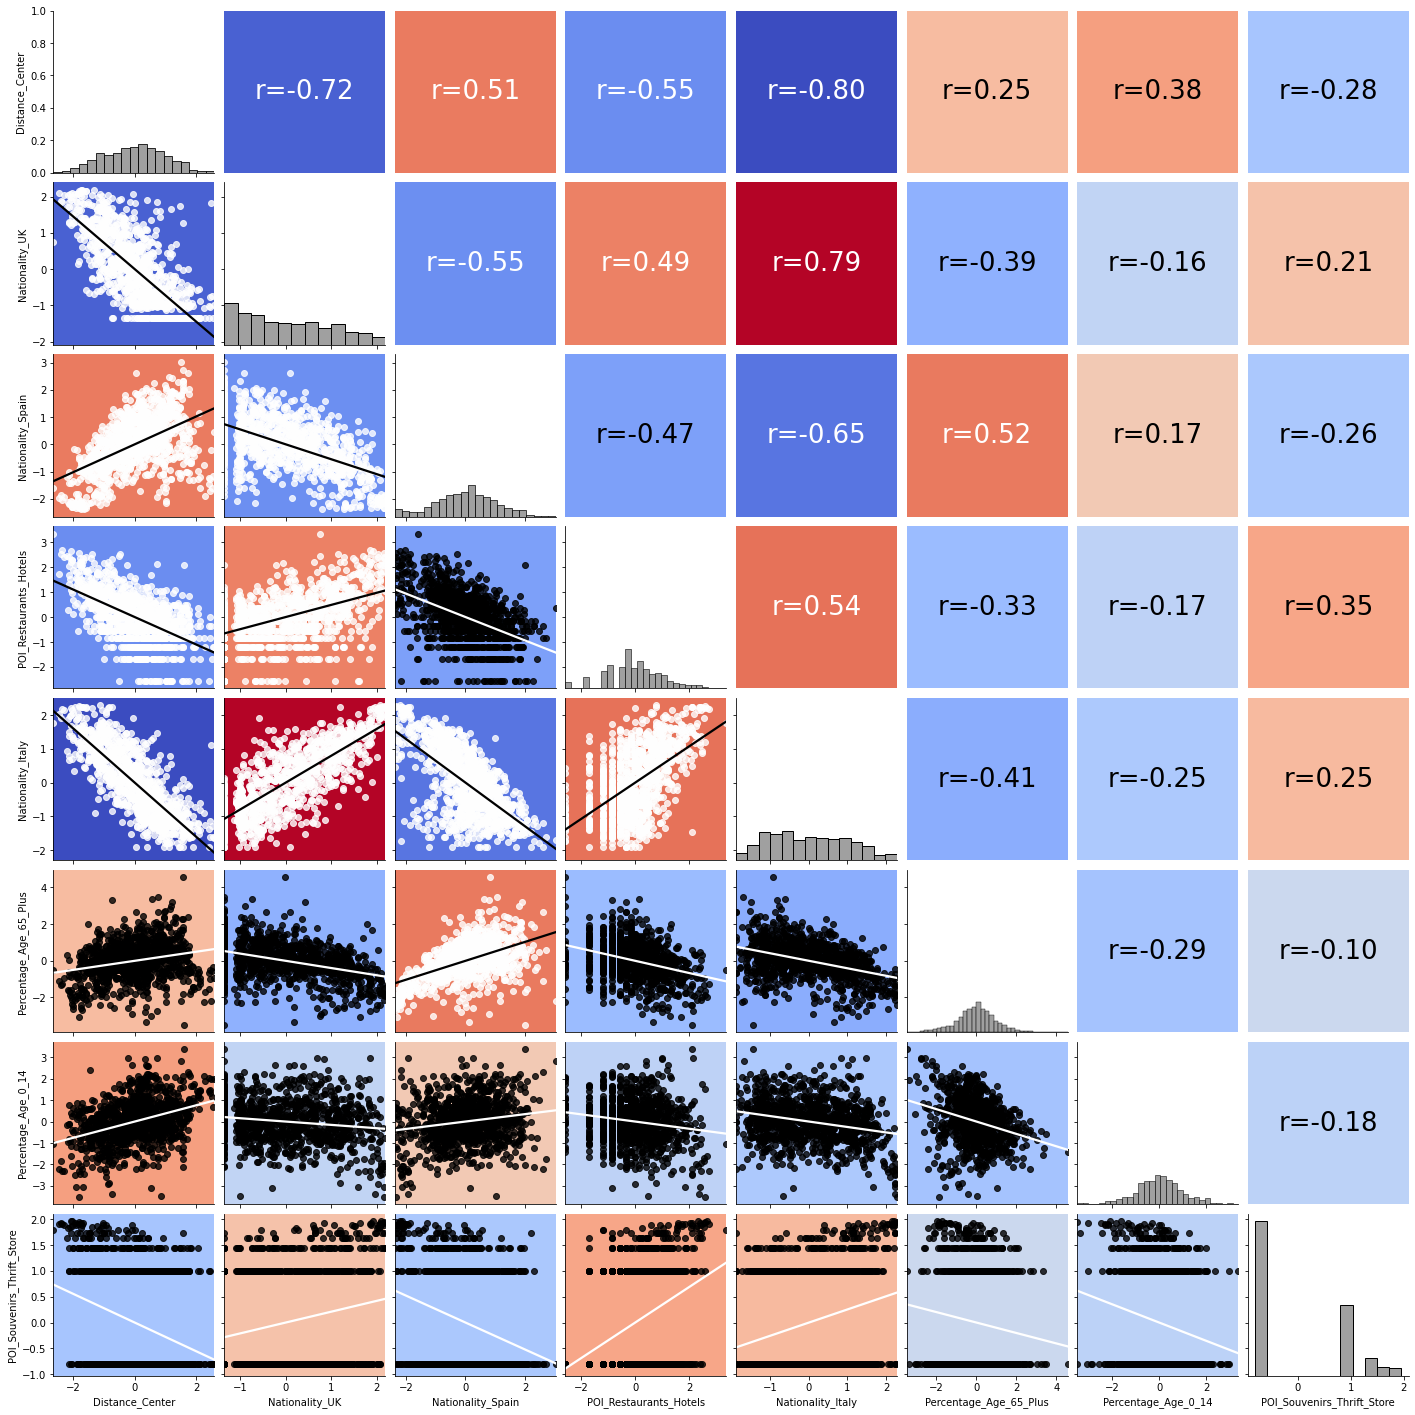

In [17]:
def corrfunc(x, y, **kwds):
    cmap = kwds["cmap"]
    norm = kwds["norm"]
    ax = plt.gca()
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    ax.set_facecolor(facecolor)
    lightness = (max(facecolor[:3]) + min(facecolor[:3])) / 2
    ax.annotate(
        f"r={r:.2f}",
        xy=(0.5, 0.5),
        xycoords=ax.transAxes,
        color="white" if lightness < 0.7 else "black",
        size=26,
        ha="center",
        va="center",
    )


def scattfunc(x, y, **kwds):
    cmap = kwds["cmap"]
    norm = kwds["norm"]
    ax = plt.gca()
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    lightness = (max(facecolor[:3]) + min(facecolor[:3])) / 2
    myColor = "white" if lightness < 0.7 else "black"
    lineColor = "black" if lightness < 0.7 else "white"
    ax.set_facecolor(facecolor)
    sns.regplot(x, y, ax=ax, color=myColor, line_kws={"color": lineColor}, ci=None)


g = sns.PairGrid(pd.DataFrame(X_transformed, columns=X_chosen.columns))
g.map_lower(
    scattfunc, cmap=plt.get_cmap("coolwarm"), norm=plt.Normalize(vmin=-0.8, vmax=0.8)
)
g.map_diag(sns.histplot, color="gray", kde=False)
g.map_upper(
    corrfunc, cmap=plt.get_cmap("coolwarm"), norm=plt.Normalize(vmin=-0.8, vmax=0.8)
)
g.fig.subplots_adjust(wspace=0.06, hspace=0.06)  # equal spacing in both directions


if SAVE_FIGS:
    plt.savefig(DIR_DATA / "processed/02_gwr/correlations.svg", format="svg")

In [18]:
vif = pd.DataFrame()
vif["VIF"] = [
    variance_inflation_factor(X_transformed, i) for i in range(X_transformed.shape[1])
]
vif["variable"] = X_chosen.columns

vif

VIF                    variable
0  3.506070             Distance_Center
1  3.000447              Nationality_UK
2  2.122258           Nationality_Spain
3  1.666308      POI_Restaurants_Hotels
4  4.514579           Nationality_Italy
5  1.838300      Percentage_Age_65_Plus
6  1.524617         Percentage_Age_0_14
7  1.170663  POI_Souvenirs_Thrift_Store

Now select the best k for the nearest neighbours bandwith.

In [19]:
gwr_chosen_selector = mgwr.sel_bw.Sel_BW(
    coords, y_transformed, X_transformed, fixed=False, spherical=True, multi=False
)
gwr_chosen_bw = gwr_chosen_selector.search()
print("GWR with chosen and transformed features")
print("Bandwith (KNN): " + str(int(gwr_chosen_bw)))

GWR with chosen and transformed features
Bandwith (KNN): 232


Fit the model

In [20]:
gwr_chosen_model = mgwr.gwr.GWR(coords, y_transformed, X_transformed, gwr_chosen_bw)
gwr_chosen_results = gwr_chosen_model.fit()
# gwr_chosen_results.summary()

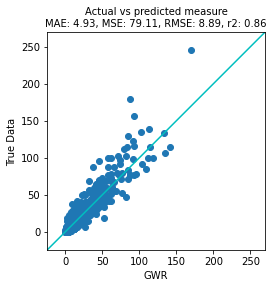

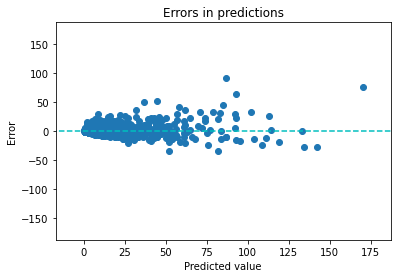

In [21]:
gwr_chosen_model.predict(coords, X_transformed)
y_predicted = gwr_chosen_results.predictions
y_predicted = pw_y.inverse_transform(y_predicted).round().flatten()
y_predicted = pd.Series(y_predicted, name="GWR")
y_truth = pd.Series(y.flatten(), name="True Data")
pa_gwr = PredictedAccuracy(y_truth, y_predicted)
pa_gwr.plot_scatter(save_fig=False, root_name="gwr_model")

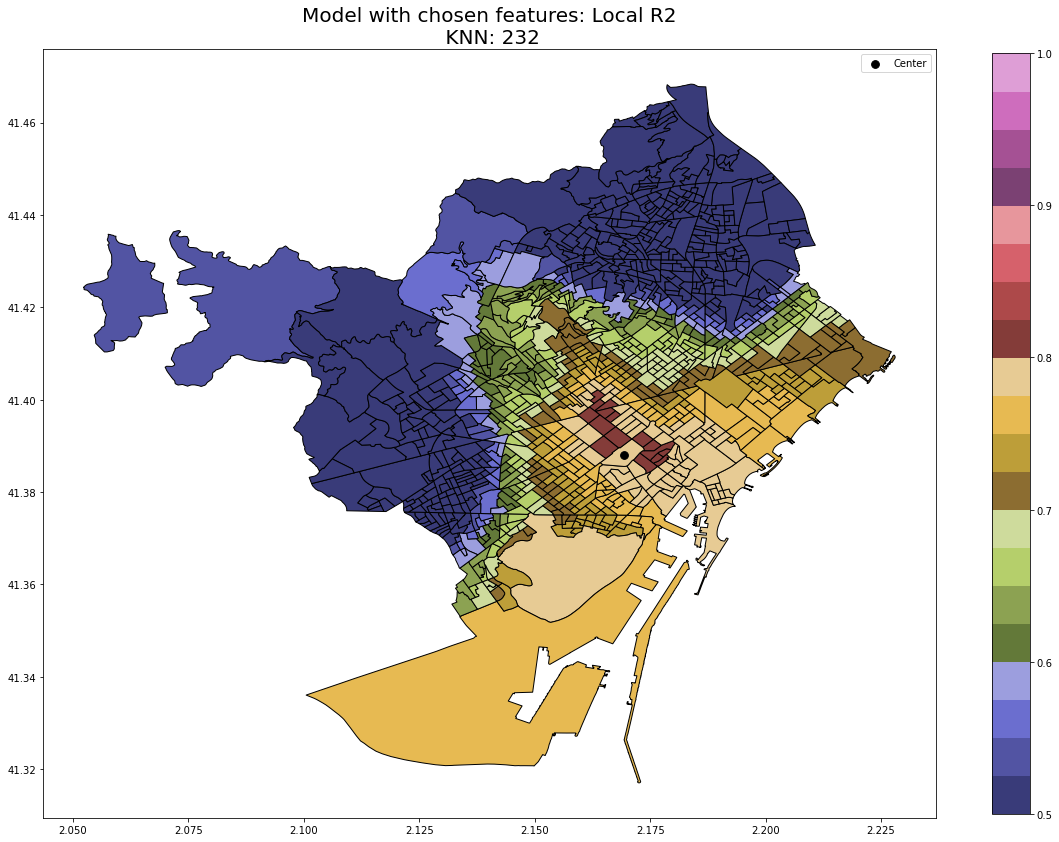

In [22]:
geo_info["Chosen_Local_R2"] = gwr_chosen_results.localR2

fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor="black",
    column="Chosen_Local_R2",
    legend=True,
    vmin=0.5,
    vmax=1,
    cmap="tab20b",
    legend_kwds={"shrink": 0.7},
)
# geo_info.centroid.plot(ax=ax, color="black", markersize=5)
sect[sect.index == id_max_airbnb].centroid.plot(
    ax=ax, color="black", markersize=60, label="Center"
)

plt.legend()

ax.set_title(
    "Model with chosen features: Local R2\n KNN: {}".format(int(gwr_chosen_bw)),
    fontsize=20,
)

if SAVE_FIGS:
    plt.savefig(DIR_DATA / "processed/02_gwr/local_r2.svg", format="svg")

plt.show()

In [23]:
geo_info["Chosen_Error"] = (
    2
    * (y_truth.values - y_predicted.values)
    / (abs(y_truth.values) + abs(y_predicted.values))
)

col_lim = max(abs(geo_info["Chosen_Error"].min()), abs(geo_info["Chosen_Error"].max()))

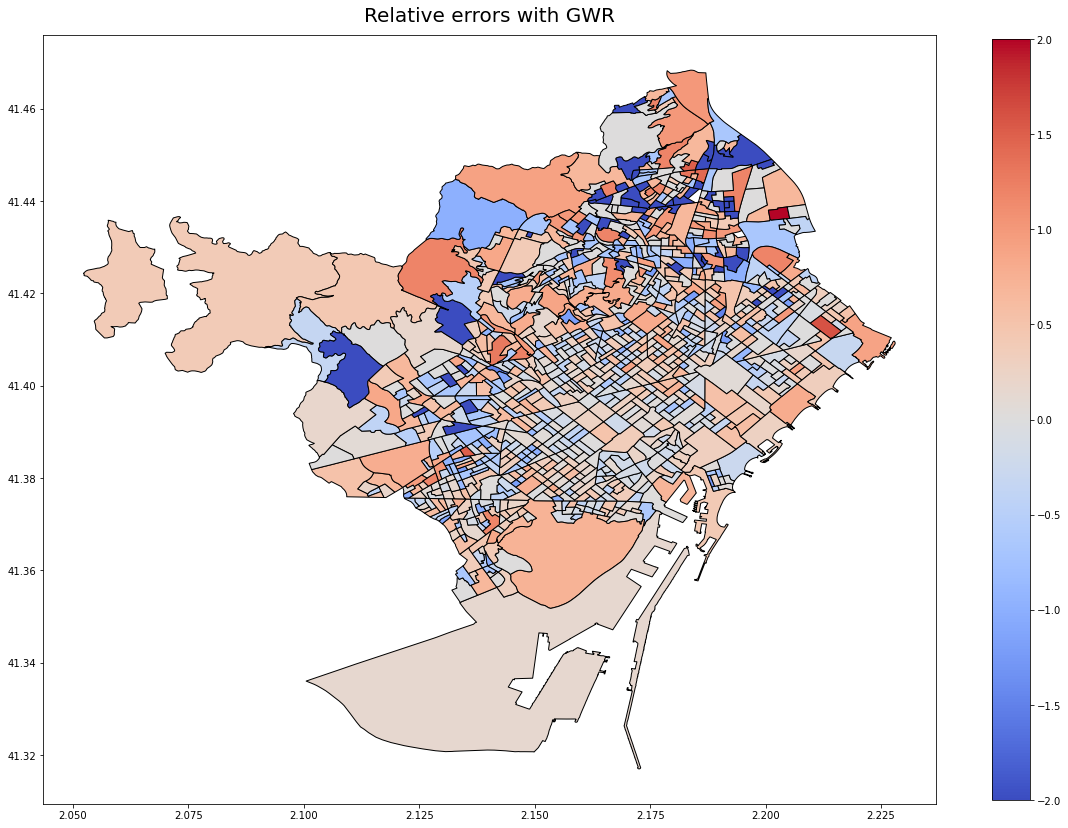

In [24]:
fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor="black",
    column="Chosen_Error",
    legend=True,
    vmin=-col_lim,
    vmax=col_lim,
    cmap="coolwarm",
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Relative errors with GWR", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_DATA / "processed/02_gwr/relative_errors.svg", format="svg")

plt.show()

In [25]:
chosen_gwr_columns = best_model.copy()
chosen_gwr_columns.insert(0, "Intercept")
coefs_chosen_gwr = pd.DataFrame(gwr_chosen_results.params, columns=chosen_gwr_columns)

medians_gwr = coefs_chosen_gwr.median()
medians_gwr = medians_gwr.reindex(medians_gwr.abs().sort_values(ascending=False).index)
coefs_chosen_gwr = coefs_chosen_gwr[medians_gwr.index]

limit_value = (
    max(abs(coefs_chosen_gwr.to_numpy().min()), abs(coefs_chosen_gwr.to_numpy().max()))
    * 1.05
)

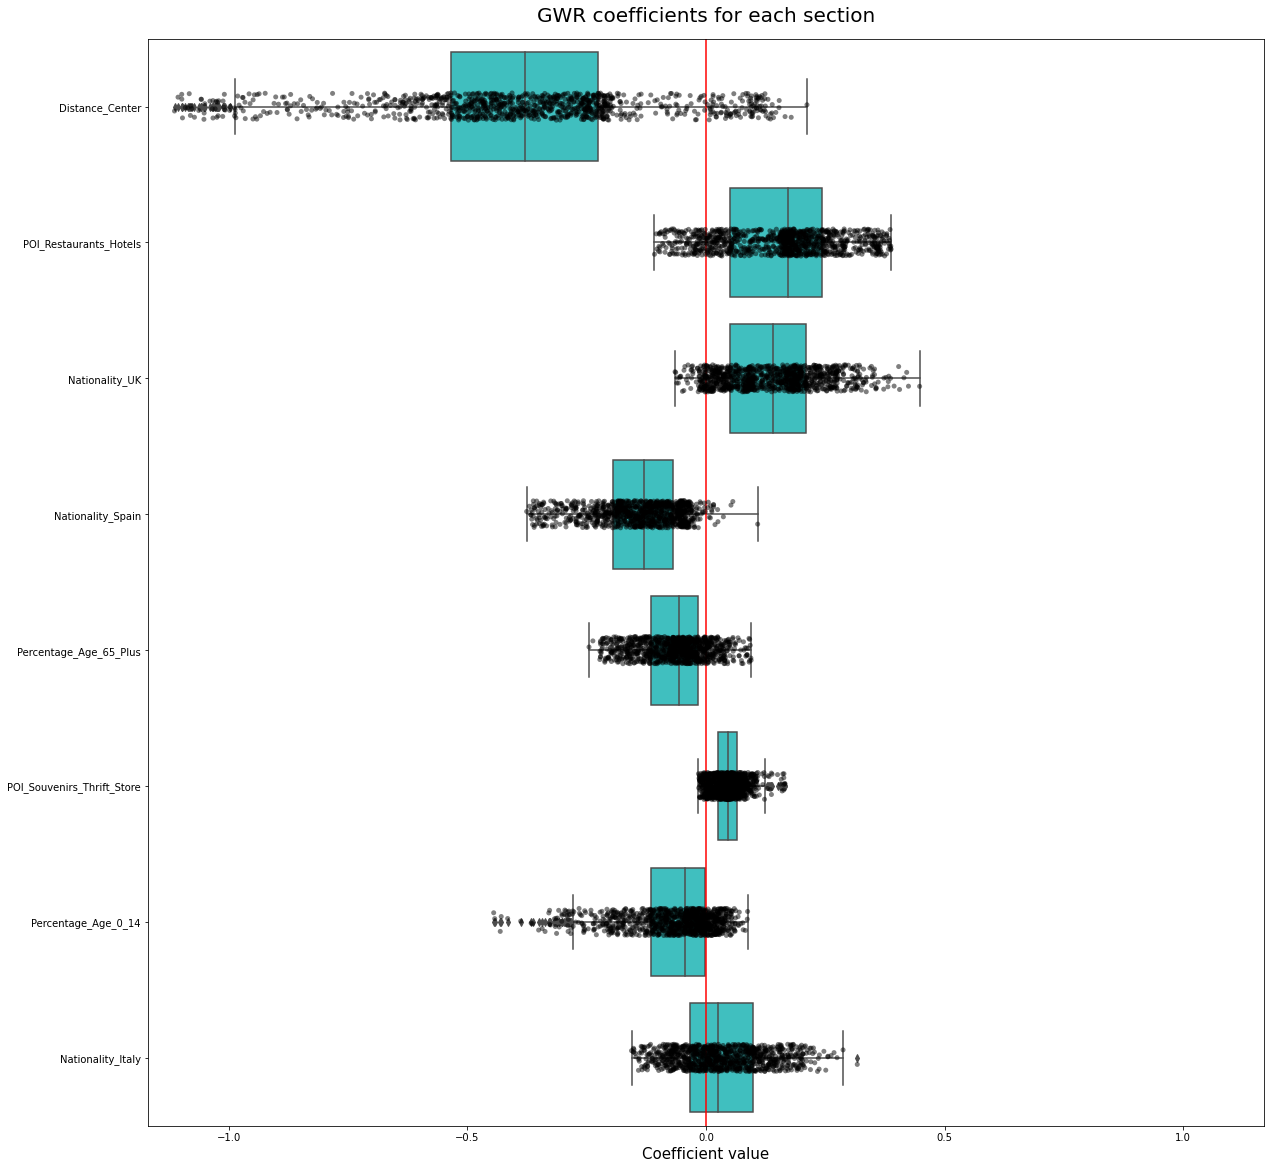

In [26]:
fig, ax = plt.subplots(figsize=(20, 20))

sns.stripplot(
    ax=ax,
    data=coefs_chosen_gwr.drop(["Intercept"], axis=1),
    orient="h",
    color="k",
    alpha=0.5,
)
sns.boxplot(
    ax=ax,
    data=coefs_chosen_gwr.drop(["Intercept"], axis=1),
    orient="h",
    color="cyan",
    saturation=0.5,
)
plt.axvline(x=0, color="red")

ax.set_title("GWR coefficients for each section", fontsize=20, y=1.01)
ax.set_xlim(-limit_value, limit_value)
ax.set_xlabel("Coefficient value", fontsize=15)

if SAVE_FIGS:
    plt.savefig(DIR_DATA / "processed/02_gwr/gwr_coefficients.svg", format="svg")

plt.show()

In [27]:
for col in coefs_chosen_gwr.columns:
    if col != "Intercept":
        geo_info[col] = coefs_chosen_gwr[col].values

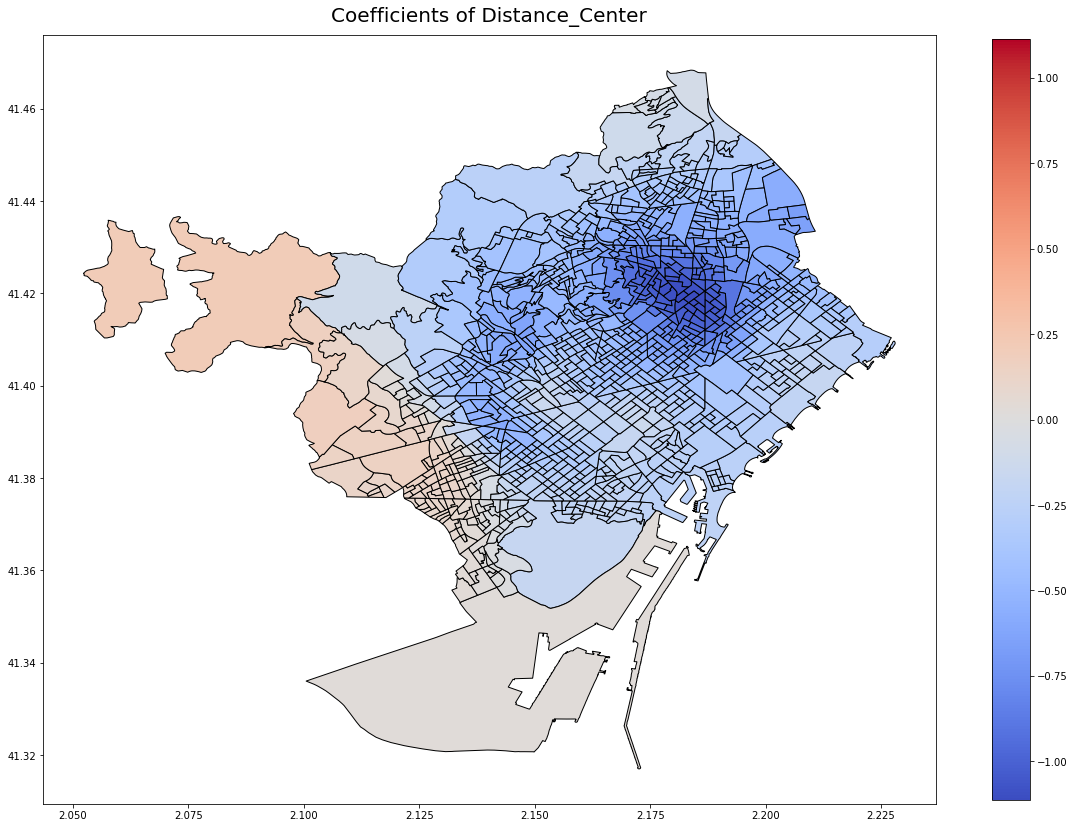

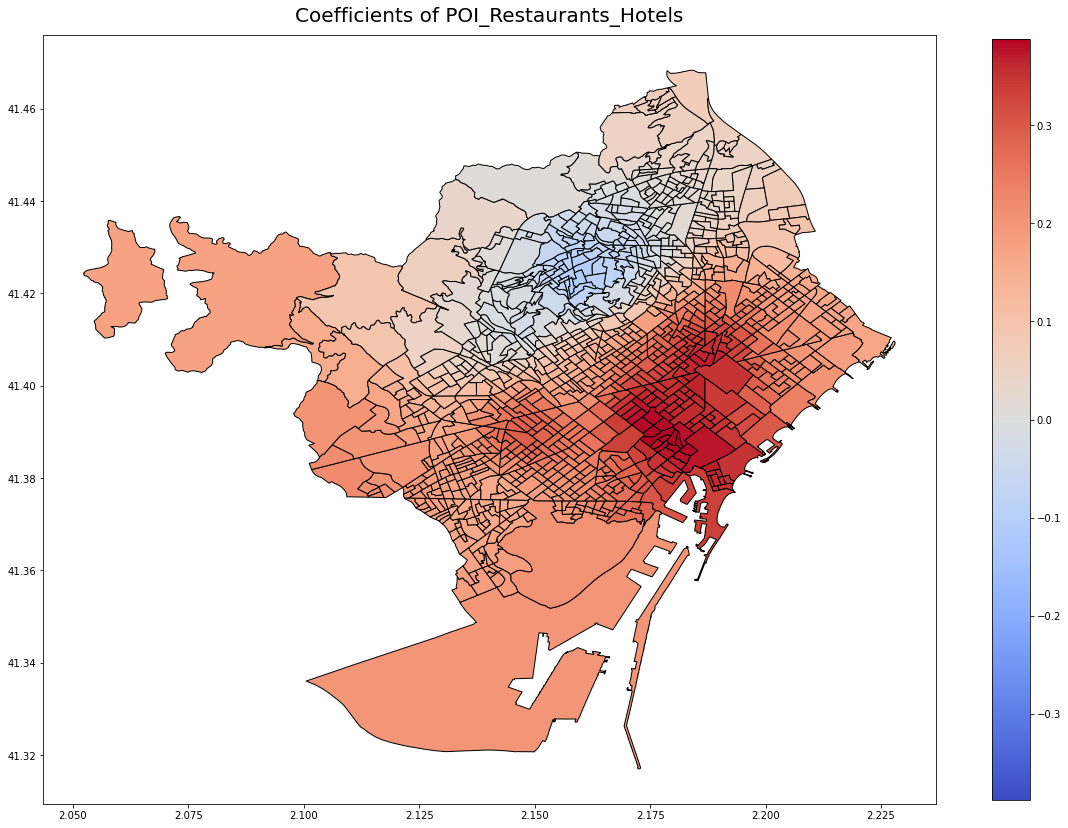

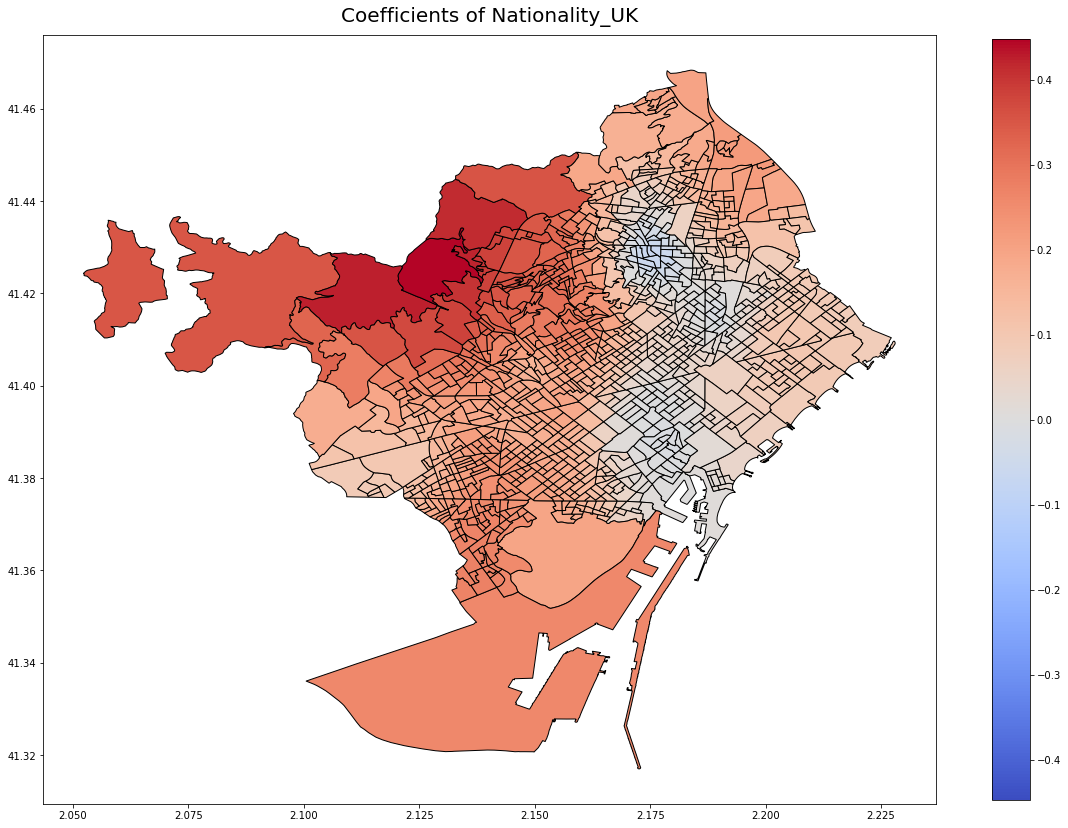

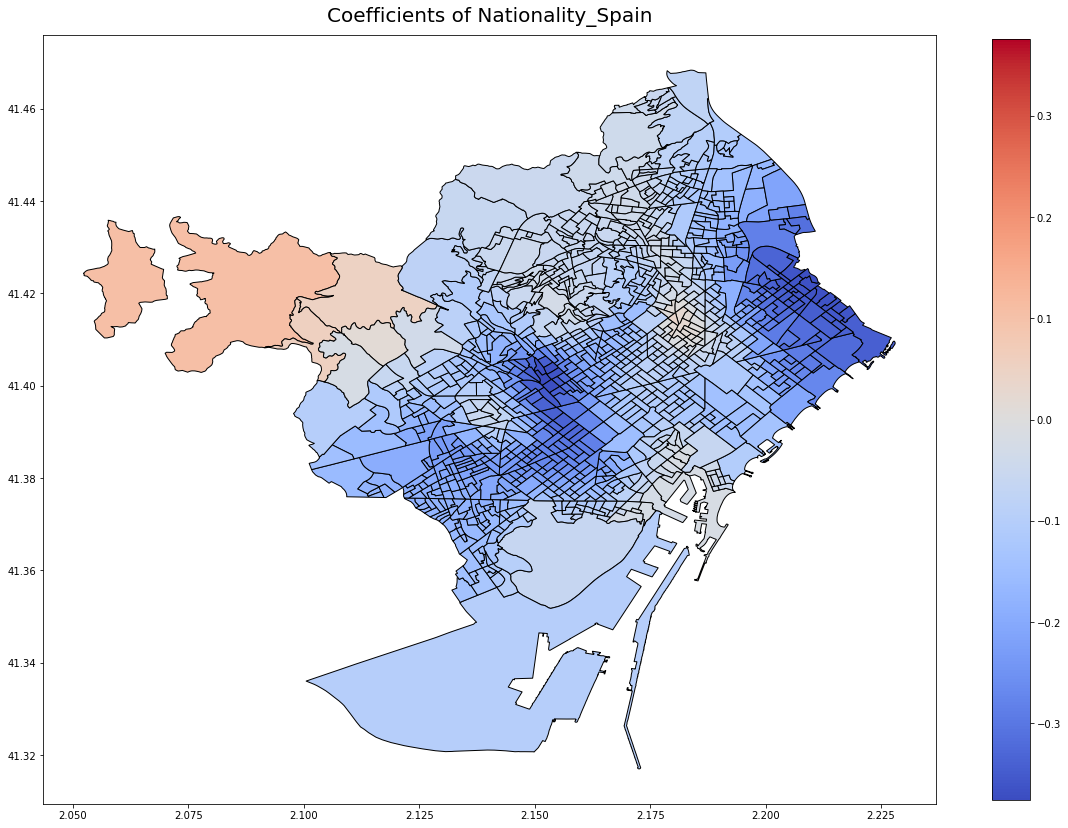

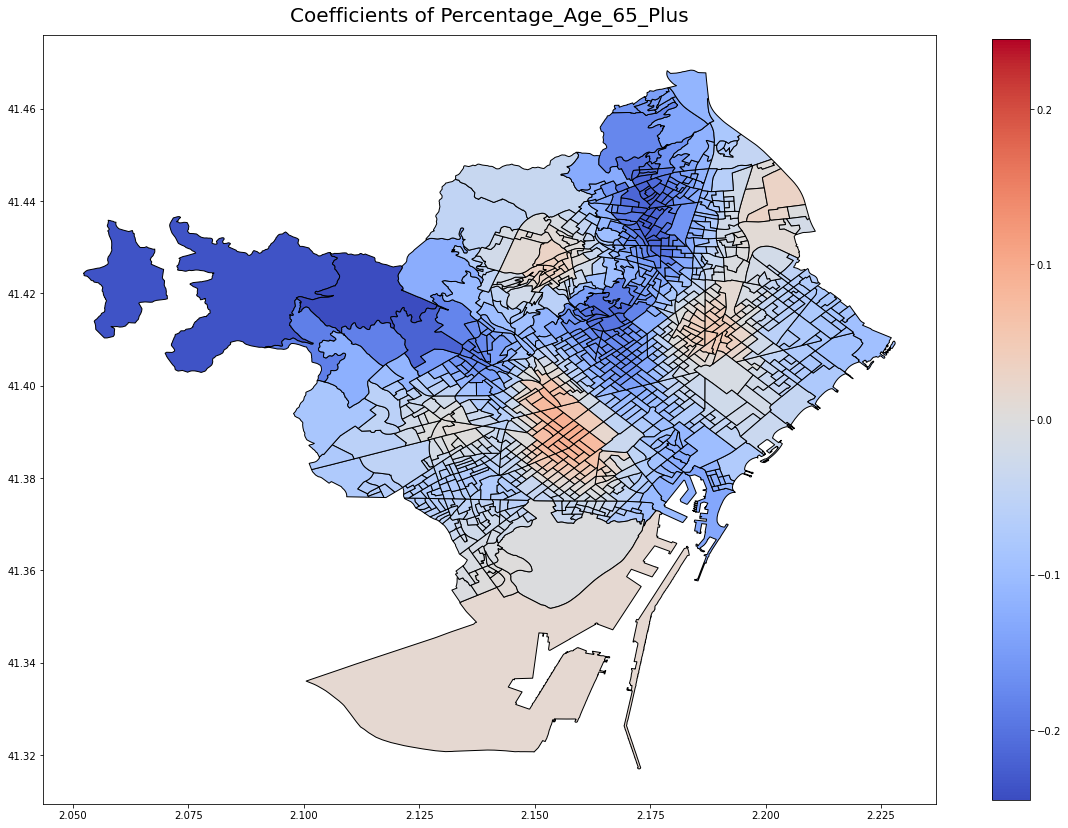

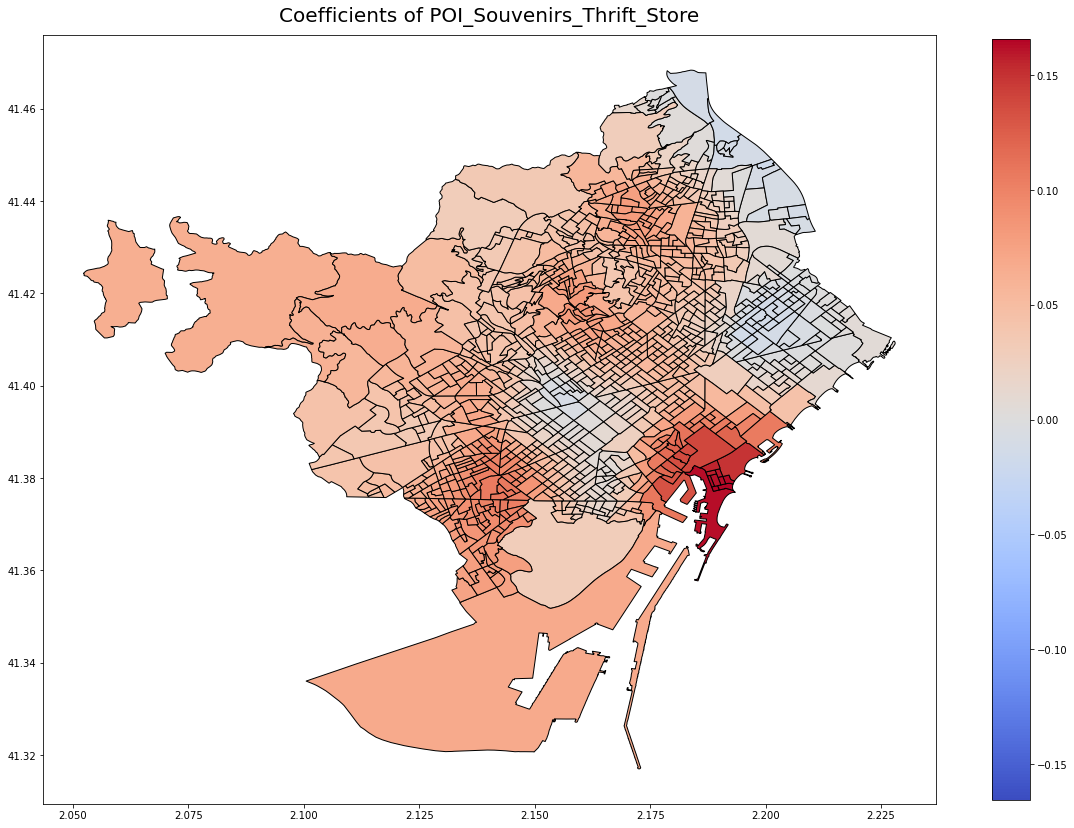

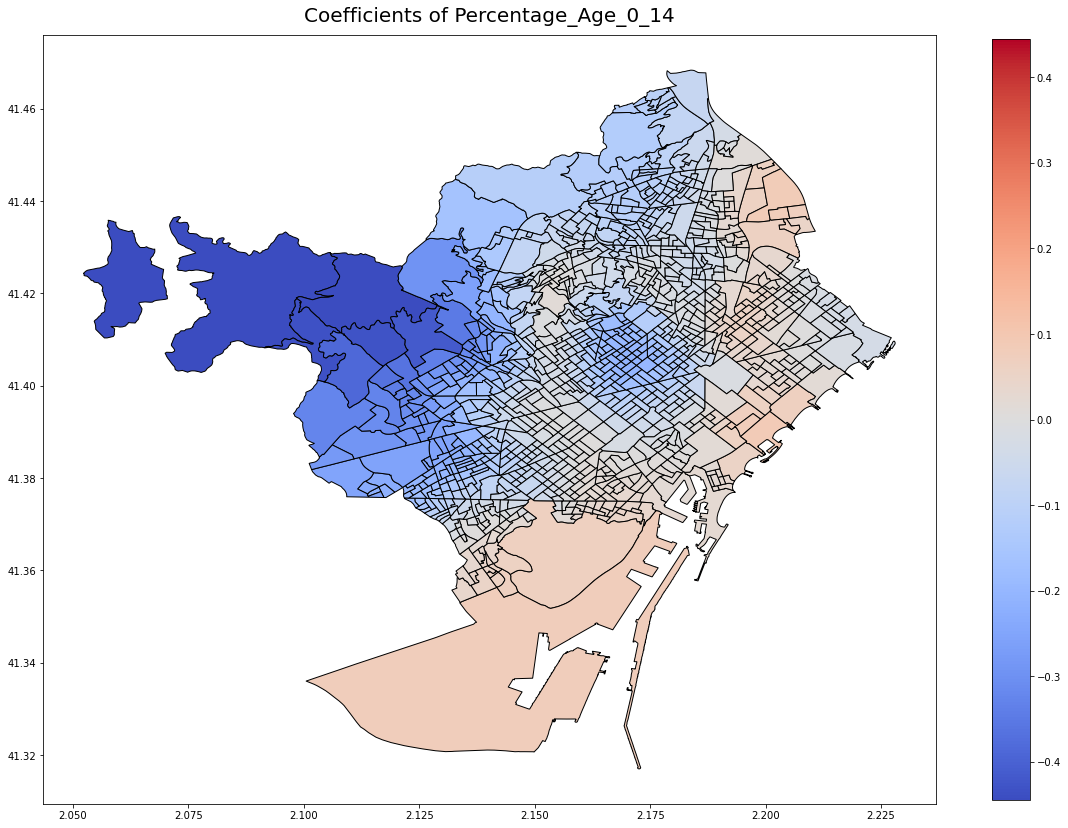

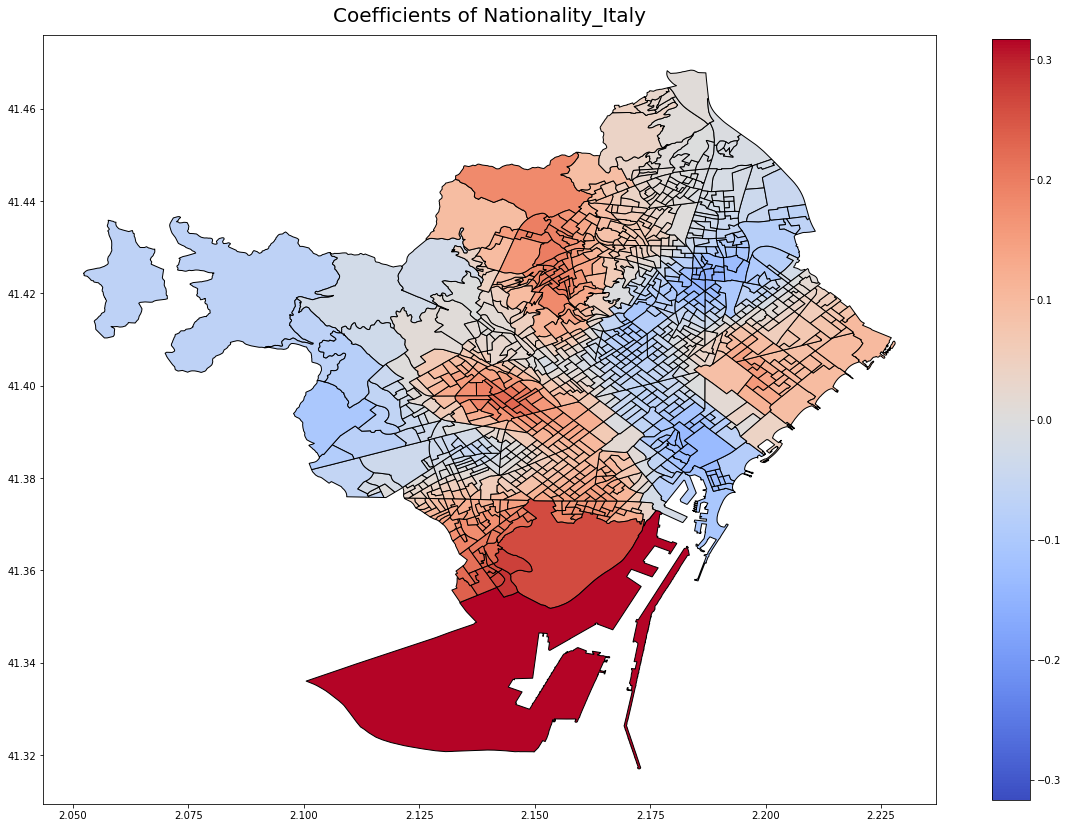

In [28]:
for col in coefs_chosen_gwr.columns:
    if col != "Intercept":
        fig, ax = plt.subplots(figsize=(20, 20))
        col_lim = max(abs(geo_info[col].min()), abs(geo_info[col].max()))
        geo_info.plot(
            ax=ax,
            edgecolor="black",
            column=col,
            legend=True,
            vmin=-col_lim,
            vmax=col_lim,
            cmap="coolwarm",
            legend_kwds={"shrink": 0.7},
        )

        ax.set_title("Coefficients of {}".format(col), fontsize=20, y=1.01)

        if SAVE_FIGS:
            plt.savefig(
                DIR_DATA / "processed/02_gwr/coefficients/{}.svg".format(col),
                format="svg",
            )

        plt.show()

In [29]:
geo_info["Chosen_Most_Important"] = (
    coefs_chosen_gwr.drop(["Intercept"], axis=1).abs().idxmax(axis=1).values
)

coefs_chosen_gwr["Chosen_Most_Important"] = (
    coefs_chosen_gwr.drop(["Intercept"], axis=1).abs().idxmax(axis=1).values
)

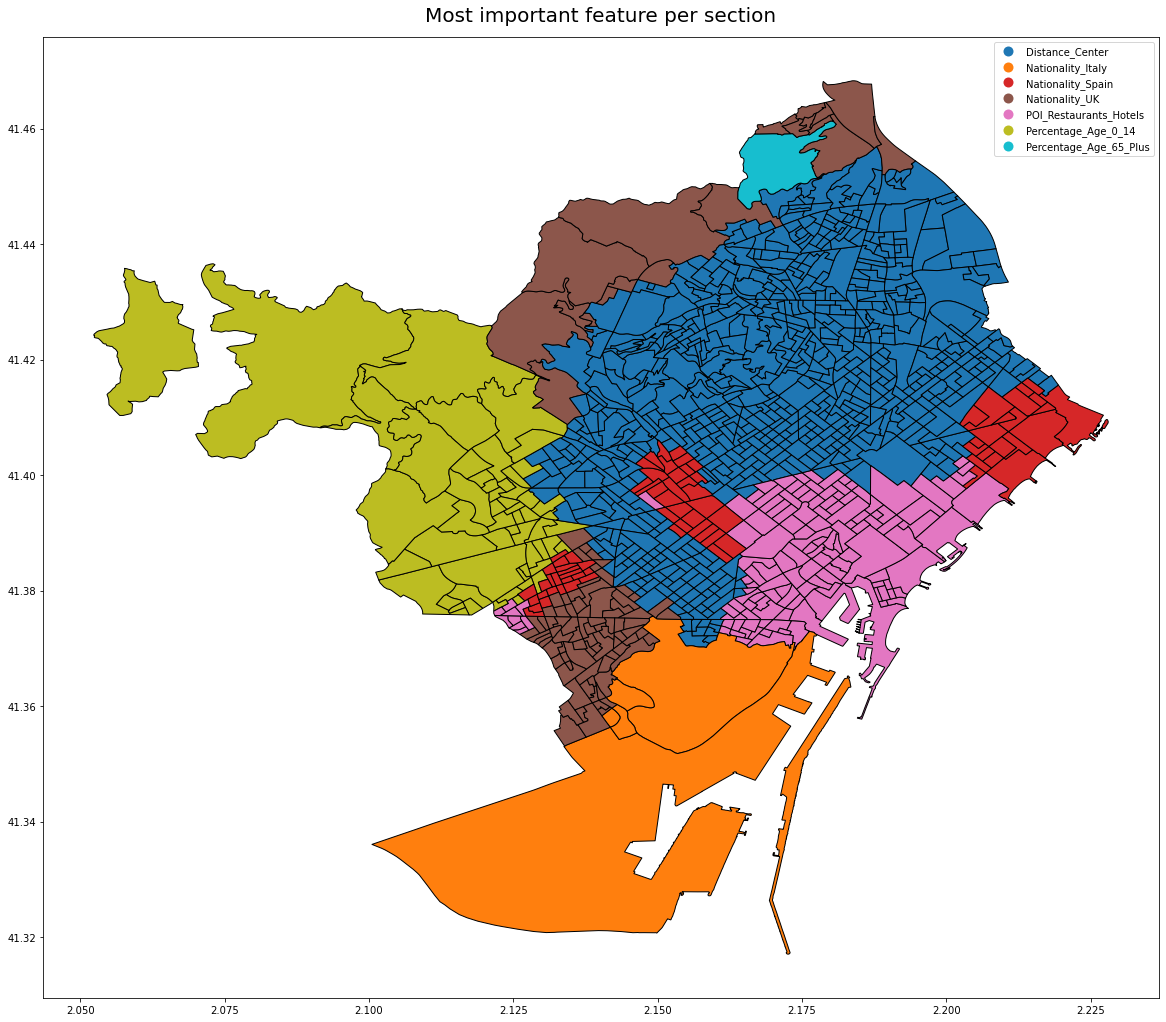

In [30]:
fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor="black",
    column="Chosen_Most_Important",
    legend=True,
)

ax.set_title("Most important feature per section", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_DATA / "processed/02_gwr/important_features.svg", format="svg")


plt.show()

# plt.savefig("important_coef.jpg")

In [31]:
# from pandas.plotting import parallel_coordinates

# for i in coefs_chosen_gwr["Chosen_Most_Important"].unique():
#     plt.figure(figsize=(20, 20))
#     parallel_coordinates(
#         frame=coefs_chosen_gwr[coefs_chosen_gwr["Chosen_Most_Important"] == i].drop(
#             ["Intercept"], axis=1
#         ),
#         class_column="Chosen_Most_Important",
#         alpha=0.5,
#         colormap="Set1",
#     )

# MGWR
All of the processes being modeled **DO NOT** operate at the same spatial scale